## Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()
    structure_eigvals_t, structure_coefficients_t, reconstructed_ldos_t = data.load_structure_gaussians()

ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


In [4]:
# importlib.reload(data)
eigen_energies, emin, emax = data.load_eigenenergies(unpack = True, n_structures = n_structures)
# gb = 0.3 #eV
# dE = 0.05 #eV

# # build the DOS of the dataset, 
# # normalized by number of atoms and number of eigenvalues
# xdos2, ldos2 = utils.build_dos(gb, eigen_energies, dE, emin, emax, n_atoms) #sigma, eigenvalues, dx, emin, emax

# xdos2_tensor = torch.tensor(xdos2)
# ldos2 *= 2
# ldos2 = torch.tensor(ldos2)

This file contains the eigenenergies and their corresponding kpoints of the training Silicon structures generated using DFT PBE as implemented in FHI-AIMS version 171221_1 with the ``tight'' settings


In [6]:
full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]

In [10]:
np.save("eigen_0", full_eigen_energies[0])

## Features PCA

In [7]:
from sklearn.decomposition import PCA

soap = Silicon.Features['structure_avedescriptors'] 
soap_pca = PCA(n_components = 1, svd_solver = "full")
soap_pca.fit(soap)

print ("SOAP PCA explained variance with 1 PCA is: {}".format(soap_pca.explained_variance_ratio_))

PCA_soap = soap_pca.transform(soap)

kernel = Silicon.Features['structure_avekerneldescriptors']
kernel_pca = PCA(n_components = 1, svd_solver = "full")
kernel_pca.fit(kernel)

print ("Kernel PCA explained variance with 1 PCA is: {}".format(kernel_pca.explained_variance_ratio_))

PCA_kernel = kernel_pca.transform(kernel)

SOAP PCA explained variance with 1 PCA is: [0.85417772]
Kernel PCA explained variance with 1 PCA is: [0.76640756]


## Translation invariant Loss function

In [378]:
importlib.reload(loss)
with torch.no_grad():
    shift_range = torch.tensor([0.05 * a for a in torch.arange(-5,5)])
    #shift_range = torch.tensor([0])
    a = loss.t_get_BF_shift_rmse(reconstructed_ldos_t, ldos, shift_range, xdos, perc = True)
    print (a)

tensor(0.5939)


## Variance Minimization

In [305]:
sigma = 0.3
dx = 0.05

full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
eigenenergy_length = [len(i) for i in full_eigen_energies]
eigenenergy_length_t = torch.tensor(eigenenergy_length)
small_index = (eigenenergy_length_t<10000)
small_index = small_index.nonzero()
small_index = small_index.flatten()
n_atoms_t = torch.tensor(n_atoms[small_index])
normalization_eiglength = [len(i) for i in eigen_energies]
normalization_eiglength_t = torch.tensor(normalization_eiglength)
normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms/normalization_eiglength_t
normalization_small = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms_t/normalization_eiglength_t[small_index]

In [306]:
torch.unique(eigenenergy_length_t, return_counts = True)

(tensor([  165,   170,   225,   230,   235,   355,  2560,  8640, 17280, 20160,
         23520, 25600, 28800, 30240, 30720, 32400, 34560, 36000, 38880, 40320,
         43200, 48000]),
 tensor([ 50,   1,  61, 152,   1,   1, 100,  69, 300,  15,   9,   3,   7,   1,
         232,   9,   9,   3,   8,   1,   5,   2]))

In [13]:
sorted_eigenergies, index = torch.sort(full_eigen_energies[0])

In [1]:
emin = -24.5537
emax = 11.3464
dx = 5E-2


ndos = int((emax-emin+3) / dx) #number of points
xdos_2 = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
binned_eigvals = torch.diff(xdos_2)/2 + xdos_2[:-1]

# adx = 5E-3 #For clusters
# c_ndos = int((emax-emin+3) / adx) #number of points
# c_xdos_2 = torch.linspace(emin-1.5, emax+1.5, c_ndos) # extend the energy grid by 3eV 
# c_binned_eigvals = torch.diff(c_xdos_2)/2 + c_xdos_2[:-1]


structure_coefficients = []
structure_eigvals = []
reconstructed_ldos = []
losses = []
for i in tqdm(range(len(full_eigen_energies))):
    if eigenenergy_length_t[i] < 400:
        evals = full_eigen_energies[i]
        coeffs = torch.ones_like(evals)
        structure_coefficients.append(coeffs)
        structure_eigvals.append(evals)

    else:
        i_xdos = xdos_2
        i_binned_eigvals = binned_eigvals
        hist = torch.histogram(full_eigen_energies[i], i_xdos)
        print (torch.sum(hist.hist > 0))
        coeffs = hist.hist[hist.hist > 0]
        evals = i_binned_eigvals[hist.hist>0]
        structure_coefficients.append(coeffs)
        structure_eigvals.append(evals)


    i_ldos = torch.sum(coeffs.view(-1,1) * (torch.exp(-0.5*(((xdos - evals.view(-1,1))/sigma)**2))), dim = 0)
    i_ldos = ((i_ldos * normalization[i]))* 2
    reconstructed_ldos.append(i_ldos)
    print (loss.t_get_rmse(i_ldos, ldos[i], xdos, perc = False))
    losses.append(loss.t_get_rmse(i_ldos, ldos[i], xdos, perc = False))

NameError: name 'torch' is not defined

In [311]:
losses_t = torch.vstack(losses)
# structure_coefficients_t = torch.vstack(structure_coefficients)
# structure_eigvals_t = torch.vstack(structure_eigvals)
reconstructed_ldos_t = torch.vstack(reconstructed_ldos)

In [317]:
# structure_coefficients_t = torch.nested.nested_tensor(structure_coefficients)
# structure_eigvals_t = torch.nested.nested_tensor(structure_eigvals)

In [339]:
structure_coefficients_t = torch.nn.utils.rnn.pad_sequence(structure_coefficients, batch_first = True)
structure_eigvals_t = torch.nn.utils.rnn.pad_sequence(structure_eigvals, batch_first = True)

In [436]:
torch.save(structure_coefficients_t, 'structure_coefficients.pt')
torch.save(structure_eigvals_t, 'structure_eigvals.pt')
torch.save(reconstructed_ldos_t, 'reconstructed_ldos.pt')

In [421]:
kernel_features = torch.tensor(PCA_kernel[train_index])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(train_index)))

In [429]:
from sklearn.linear_model import Ridge
from dostools.loss import loss
from dostools.consistency import consistency

def evaluate_performance(shifted_ldos):
    Features = copy.deepcopy(PCA_kernel)
    y_shifted = shifted_ldos.clone().detach()
    #y_shifted = consistency.shifted_ldos()

    model = Ridge(alpha = 0, fit_intercept = True, solver = 'svd')

    x = Features[train_index]
    y = y_shifted

    model.fit(x,y)

    predictions = baselinemodel.predict(x)
    train_rmse = loss.t_get_rmse(torch.tensor(baseline_predictions), y)

    # small_test_index = torch.arange(1039)
    # small_test_index[small_index] = False
    # small_test_index = small_test_index.nonzero().flatten()


#     baseline_test_predictions = baselinemodel.predict(Features[test_index])
#     test_rmse = loss.t_get_rmse(torch.tensor(baseline_test_predictions), y_shifted[test_index])

    print(train_rmse)
#     print(test_rmse)
    return train_rmse#, test_rmse

In [435]:
alignment = torch.nn.parameter.Parameter(torch.zeros(len(train_index)))
lr = 0.1
n_epochs = 100000
optimizer = torch.optim.Adam(
        [alignment],
        lr=lr)#,  line_search_fn="strong_wolfe")

all_losses = []
all_train_loss = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 30)#0.5)
for epoch in tqdm(range(n_epochs)):
    def closure():
        optimizer.zero_grad()
        new_dos = (torch.sum((structure_coefficients_t[train_index].view(1, 831, 687) * (torch.exp(-0.5*((alignment.view(1,-1,1) + xdos.view(-1,1,1) - structure_eigvals_t[train_index])/sigma)**2))), dim = 2)).T * normalization[train_index].view(-1,1) * 2
        #pc_loss = torch.sum((1 - ((torch.corrcoef(torch.hstack([kernel_features, new_dos]).T)[0][1:]))**2))
        #pc_loss.backward()
        var_loss = torch.sum(torch.var(new_dos, dim = 0, unbiased = False))
        #return pc_loss
        return var_loss
    pc_loss = optimizer.step(closure)
    scheduler.step(pc_loss)
    
    print ("The pc_loss at epoch {} is : {}".format(epoch, pc_loss))
    new_dos = (torch.sum((structure_coefficients_t[train_index].view(1, 831, 687) * (torch.exp(-0.5*((alignment.view(1,-1,1) + xdos.view(-1,1,1) - structure_eigvals_t[train_index])/sigma)**2))), dim = 2)).T * normalization[train_index].view(-1,1) * 2
    train_loss = evaluate_performance(new_dos)
    all_losses.append(pc_loss)
    all_train_loss.append(train_loss)



  0%|                                                                                                                                                                           | 0/100000 [00:00<?, ?it/s]

The pc_loss at epoch 0 is : 6.90689086440562


  0%|                                                                                                                                                               | 1/100000 [00:24<684:50:50, 24.65s/it]

tensor(0.0613)
The pc_loss at epoch 1 is : 6.90689086440562


  0%|                                                                                                                                                               | 2/100000 [00:49<686:43:01, 24.72s/it]

tensor(0.0613)
The pc_loss at epoch 2 is : 6.90689086440562


  0%|                                                                                                                                                               | 3/100000 [01:16<710:24:44, 25.58s/it]

tensor(0.0613)


  0%|                                                                                                                                                               | 3/100000 [01:28<821:12:35, 29.56s/it]


KeyboardInterrupt: 

In [ ]:
#0.0613 is default

In [411]:
z = (torch.sum((structure_coefficients_t[train_index].view(1, 831, 687) * (torch.exp(-0.5*((alignment.view(1,-1,1) + xdos.view(-1,1,1) - structure_eigvals_t[train_index])/sigma)**2))), dim = 2)).T * normalization[train_index].view(-1,1) * 2


torch.Size([831, 778])


In [412]:
k = loss.t_get_mse(z, reconstructed_ldos_t[train_index])

In [413]:
k

tensor(3.2786e-33, grad_fn=<MeanBackward1>)

In [394]:
structure_coefficients_t[train_index].shape

torch.Size([831, 687])

In [388]:
structure_eigvals_t[train_index[0]][0]

tensor(-20.7719)

In [389]:
z[0,0,0]

tensor(-5.2818, grad_fn=<SelectBackward0>)

In [ ]:
i_ldos = torch.sum(coeffs.view(-1,1) * (torch.exp(-0.5*(((xdos - evals.view(-1,1))/sigma)**2))), dim = 0)

In [ ]:
ldos = 

In [330]:
structure_eigvals_t + alignment

RuntimeError: Expected both self and other to be nested, but got a nested self and non-nested other

In [331]:
lengths = [len(a) for a in structure_coefficients]

In [333]:
lengths = torch.tensor(lengths)
print (lengths.max())
print (lengths.min())

tensor(687)
tensor(165)


/tmp/ipykernel_43144/649679528.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths = torch.tensor(lengths)


In [11]:
kernel_features = torch.tensor(PCA_kernel[small_index])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(small_index)))

In [12]:
def generate_energy_index(eigenenergy_length):
    n_structures = len(eigenenergy_length)
    total_index = []
    for i, e_vals in enumerate(eigenenergy_length):
        indiv_index = torch.zeros(e_vals) + i
        total_index.append(indiv_index)
    total_index = torch.hstack(total_index)
    return total_index.long()

In [13]:
energy_index = generate_energy_index(eigenenergy_length)

In [14]:
energies = torch.hstack(full_eigen_energies).view(-1,1)

In [15]:
def torch_generate_dos(energies, eigenenergy_length_t, normalization, splits):
    ldoses = []
    for i in tqdm(range(len(splits) - 1)):
        indexes = generate_energy_index(eigenenergy_length_t[splits[i]:splits[i+1]])
        E = energies[torch.sum(eigenenergy_length_t[:splits[i]]):torch.sum(eigenenergy_length_t[:splits[i]]) + torch.sum(eigenenergy_length_t[splits[i]:splits[i+1]])]
        split_ldos = torch.zeros(splits[i+1] - splits[i], len(xdos))
        
        new_ldos = (torch.exp(-0.5*((xdos - E)/sigma)**2))
        
        split_ldos.index_add_(0, indexes, new_ldos)
        
        ldoses.append(split_ldos)
    ldoses = torch.vstack(ldoses)     
    
    final_ldos = ((ldoses.T * normalization ).T)* 2
    return final_ldos
    


In [16]:
# ldos2 = torch_generate_dos(energies, eigenenergy_length_t, normalization, [0, 100, 200, 300, 400, 500, 800, 1039])

In [17]:
alignment.shape

torch.Size([435])

In [18]:
lr = 100
n_epochs = 1000



In [19]:
sigma = torch.tensor(0.3)
dx = 0.05

emin = -24.5537
emax = 11.3464


ndos = int((emax-emin+3) / dx) #number of points
xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos = torch.zeros((len(small_index), ndos))
for i in tqdm(range(len(small_index))):#for every structure    
    ldos[i] = torch.sum(torch.exp(-0.5*((alignment[i] + xdos - full_eigen_energies[small_index[i]].view(-1,1))/sigma)**2), dim = 0)

final_ldos = ((ldos.T * normalization ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:05<00:00, 75.96it/s]


In [20]:
loss = torch.sum((1 - torch.abs((torch.corrcoef(torch.hstack([kernel_features, final_ldos]).T)[0][1:])))**2)

In [21]:
print (loss)

tensor(212.8861, grad_fn=<SumBackward0>)


In [ ]:
lr = 0.01
alignment = torch.nn.parameter.Parameter(torch.zeros(len(small_index)))
n_epochs = 1000

optimizer = torch.optim.Adam(
                [alignment],
                lr=lr)#,  line_search_fn="strong_wolfe")

for i in tqdm(range(n_epochs)):
    def closure():
        optimizer.zero_grad()
        sigma = torch.tensor(0.3)
        dx = 0.05

        emin = -24.5537
        emax = 11.3464


        ndos = int((emax-emin+3) / dx) #number of points
        xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
        ldos = torch.zeros((len(small_index), ndos))
        for i in (range(len(small_index))):#for every structure    
            ldos[i] = torch.sum(torch.exp(-0.5*((alignment[i] + xdos - full_eigen_energies[small_index[i]].view(-1,1))/sigma)**2), dim = 0)

        final_ldos = ((ldos.T * normalization ).T)* 2
        pc_loss = torch.sum((1 - torch.abs((torch.corrcoef(torch.hstack([kernel_features, final_ldos]).T)[0][1:])))**2)
        #print (pc_loss)
        pc_loss.backward()
        return pc_loss
    
    mse = optimizer.step(closure)
    
    print (mse)

  0%|▏                                                                                                                                                                  | 1/1000 [00:09<2:45:56,  9.97s/it]

tensor(212.8861, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                                  | 2/1000 [00:21<2:56:37, 10.62s/it]

tensor(212.1835, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                                  | 3/1000 [00:29<2:41:25,  9.71s/it]

tensor(207.9559, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                                  | 4/1000 [00:37<2:27:05,  8.86s/it]

tensor(204.2679, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                                  | 5/1000 [00:45<2:25:24,  8.77s/it]

tensor(202.9791, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                                  | 6/1000 [00:54<2:23:37,  8.67s/it]

tensor(203.2197, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                                 | 7/1000 [01:02<2:21:07,  8.53s/it]

tensor(203.7145, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                                 | 8/1000 [01:10<2:20:22,  8.49s/it]

tensor(203.2850, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                                 | 9/1000 [01:18<2:16:03,  8.24s/it]

tensor(202.0296, grad_fn=<SumBackward0>)


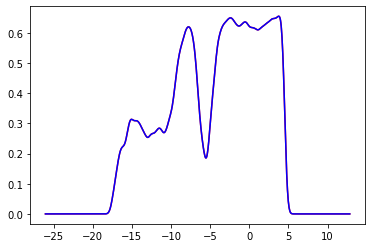

In [80]:
%matplotlib inline
index = 50
plt.plot(xdos, o_ldos[small_index[index]], c = 'r')
plt.plot(xdos, final_ldos[index].detach(), c = 'b')

torch.corrcoef
torch.var

In [24]:
tol = 1E-4
print (torch.sum(test_ldos > tol))

plt.plot(xdos[(test_ldos > tol)], test_ldos[(test_ldos > tol)])

tensor(552253)


NameError: name 'test_ldos' is not defined

In [22]:
len(xdos[(test_ldos > tol)])

NameError: name 'test_ldos' is not defined

In [212]:
ldos[0]

tensor([6.3422e-155, 5.0089e-153, 3.8472e-151, 2.8738e-149, 2.0878e-147,
        1.4751e-145, 1.0136e-143, 6.7735e-142, 4.4023e-140, 2.7826e-138,
        1.7105e-136, 1.0226e-134, 5.9460e-133, 3.3623e-131, 1.8491e-129,
        9.8900e-128, 5.1445e-126, 2.6026e-124, 1.2805e-122, 6.1272e-121,
        2.8514e-119, 1.2906e-117, 5.6807e-116, 2.4319e-114, 1.0125e-112,
        4.0999e-111, 1.6146e-109, 6.1840e-108, 2.3035e-106, 8.3453e-105,
        2.9404e-103, 1.0076e-101, 3.3580e-100,  1.0885e-98,  3.4313e-97,
         1.0520e-95,  3.1370e-94,  9.0977e-93,  2.5661e-91,  7.0396e-90,
         1.8782e-88,  4.8739e-87,  1.2301e-85,  3.0194e-84,  7.2086e-83,
         1.6738e-81,  3.7801e-80,  8.3031e-79,  1.7738e-77,  3.6858e-76,
         7.4489e-75,  1.4642e-73,  2.7993e-72,  5.2054e-71,  9.4147e-70,
         1.6562e-68,  2.8339e-67,  4.7164e-66,  7.6348e-65,  1.2021e-63,
         1.8411e-62,  2.7426e-61,  3.9740e-60,  5.6011e-59,  7.6789e-58,
         1.0240e-56,  1.3284e-55,  1.6761e-54,  2.0

In [154]:
sigma = torch.tensor(0.3)
dx = 0.05

ndos = int((emax-emin+3) / dx) #number of points
xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos = torch.zeros((len(full_eigen_energies), ndos))
for i in tqdm(range(len(full_eigen_energies))):#for every structure    
    for ei in full_eigen_energies[i]:#for every energy level
        ldos[i] += torch.exp(-0.5*((xdos[:]-ei)/sigma)**2) #puts a gaussian centered on the energy level
    ldos[i] *= 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms[i]/len(full_eigen_energies[i]) #normalize

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [13:33<00:00,  1.28it/s]


In [181]:
sigma = torch.tensor(0.3)
dx = 0.05

ndos3 = int((emax-emin+3) / dx) #number of points
xdos3 = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos3 = torch.zeros((len(full_eigen_energies), ndos))
for i in tqdm(range(len(eigen_energies))):#for every structure    
    for ei in full_eigen_energies[i]:#for every energy level
        ldos3[i] += torch.exp(-0.5*((xdos[:]-ei)/sigma)**2) #puts a gaussian centered on the energy level
    ldos3[i] *= 1/torch.sqrt(2*np.pi*sigma**2)/n_atoms[i]/len(eigen_energies[i]) #normalize

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [13:40<00:00,  1.27it/s]


In [139]:
from sklearn.decomposition import PCA

soap = Silicon.Features['structure_avedescriptors'] 
soap_pca = PCA(n_components = 1, svd_solver = "full")
soap_pca.fit(soap)

print ("SOAP PCA explained variance with 1 PCA is: {}".format(soap_pca.explained_variance_ratio_))

PCA_soap = soap_pca.transform(soap)

kernel = Silicon.Features['structure_avekerneldescriptors']
kernel_pca = PCA(n_components = 1, svd_solver = "full")
kernel_pca.fit(kernel)

print ("Kernel PCA explained variance with 1 PCA is: {}".format(kernel_pca.explained_variance_ratio_))

PCA_kernel = kernel_pca.transform(kernel)

SOAP PCA explained variance with 1 PCA is: [0.85417772]
Kernel PCA explained variance with 1 PCA is: [0.76640756]


In [146]:
soap_pca.components_

array([[-3.49913423e-03, -1.76411215e-02,  3.32522948e-02,
         3.61629233e-01,  1.87222390e-01,  7.49472932e-02,
         7.73753721e-02,  2.89413546e-02, -1.76411215e-02,
         7.01613627e-04, -6.64714922e-03, -1.96539716e-02,
        -1.21993389e-02, -6.67081254e-03, -4.36700539e-03,
        -1.68577363e-03,  3.32522948e-02, -6.64714922e-03,
         2.20352739e-02,  1.41889410e-01,  7.26851954e-02,
         3.15241013e-02,  2.88627511e-02,  1.08549650e-02,
         3.61629233e-01, -1.96539716e-02,  1.41889410e-01,
         4.92546963e-01,  2.89406316e-01,  1.51981690e-01,
         1.06534352e-01,  4.10607729e-02,  1.87222390e-01,
        -1.21993389e-02,  7.26851954e-02,  2.89406316e-01,
         1.62030561e-01,  8.08235013e-02,  6.02749031e-02,
         2.31914869e-02,  7.49472932e-02, -6.67081254e-03,
         3.15241013e-02,  1.51981690e-01,  8.08235013e-02,
         3.70043392e-02,  3.02939232e-02,  1.15274716e-02,
         7.73753721e-02, -4.36700539e-03,  2.88627511e-0

## Baseline Model (SOAP)

In [325]:
from sklearn.linear_model import Ridge
from dostools.loss import loss
from dostools.consistency import consistency

Features = copy.deepcopy(PCA_kernel)
o_ldos = torch.tensor(data.load_ldos())
o_ldos *= 2
y_pw = o_ldos# - o_ldos[train_index].mean(axis = 0)
y_shifted = copy.deepcopy(y_pw)
#y_shifted = consistency.shifted_ldos()

baselinemodel = Ridge(alpha = 0, fit_intercept = True, solver = 'svd')

x = Features[train_index]
y = y_shifted[train_index]

baselinemodel.fit(x,y)

baseline_predictions = baselinemodel.predict(x)
train_rmse = loss.t_get_rmse(torch.tensor(baseline_predictions), y)

# small_test_index = torch.arange(1039)
# small_test_index[small_index] = False
# small_test_index = small_test_index.nonzero().flatten()


baseline_test_predictions = baselinemodel.predict(Features[test_index])
test_rmse = loss.t_get_rmse(torch.tensor(baseline_test_predictions), y_shifted[test_index])

print(train_rmse)
print(test_rmse)

tensor(0.0613)
tensor(0.0636)


## Misc Visualizations

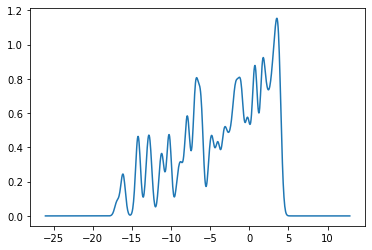

In [326]:
plt.plot(xdos, ldos[700])

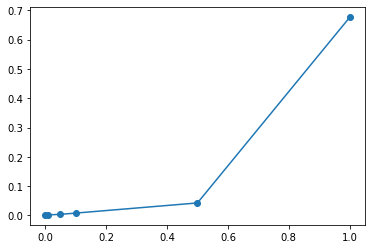

In [194]:
plt.plot(np.array([1,0.5,0.1,0.05,0.01,0.001]), np.array([0.6768, 0.0426, 0.0079, 0.0036, 0.0019, 0.0017]))
plt.scatter(np.array([1,0.5,0.1,0.05,0.01,0.001]), np.array([0.6768, 0.0426, 0.0079, 0.0036, 0.0019, 0.0017]))

In [ ]:
1
tensor(24)
tensor(0.6768)

5E-1
tensor(49)
tensor(0.0426)


1E-1
tensor(245)
tensor(0.0079)

5E-2
tensor(484)
tensor(0.0036)

1E-2 
tensor(2149)
tensor(0.0019)

1E-3
tensor(7013)
tensor(0.0017)